<a href="https://colab.research.google.com/github/mdavydenko/tf2demo/blob/master/tf2wrw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Go to Tools -> Preferences -> Power level & select ''Many power'

**Next, run the installation part:**

In [7]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==2.0.0-alpha0 

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from tensorflow.linalg import expm, sqrtm
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import math as m

Name: tensorflow
Version: 2.0.0a0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, termcolor, numpy, astor, tf-estimator-nightly, grpcio, absl-py, keras-preprocessing, protobuf, google-pasta, keras-applications, wheel, gast, tb-nightly
Required-by: stable-baselines, magenta, fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0a0)


**Next we define some functions (Ricker wavelet,etc..) and define the forward modelling operator by FWMod() function**

In [0]:
def ricker(f, nf, df=0.001):
    w = df*np.arange(nf,dtype=np.complex64);
    y=w*w/f/f/f/m.sqrt(m.pi)*np.exp(-w*w/f/f)
    return np.transpose(y+1j*0*y)

#@tf.function
def FWMod(nmod,down,up,dx,df,P,S,Pplu,Pmin,Rup,Rdown,Tup,Tdown,C):
    nz=C.shape[1]
    nfreq=P.shape[0]
    nx=P.shape[1]
    ns=P.shape[2]
    omega=1+2*m.pi*df*np.arange(0,nfreq)
    ntap=5
    Taper=np.ones([nfreq,nx,ns])
    for si in range(ns):
        for ifreq in range(nfreq):
            Taper[ifreq,ntap:nx-ntap,si]=1
            Taper[ifreq,0:ntap,si]=np.arange(0,1,1/ntap)
            Taper[ifreq,nx-ntap-1 : nx-1,si]=np.arange(1,0,-1/ntap)

    k_x=np.hstack((np.arange(0,(nx/2)),np.arange(-(nx/2),-1)))*2*m.pi/nx/dx
    x=np.arange(nx)
    [x,om]=np.complex64(np.meshgrid(x, omega))

    [fk_k,fk_f]=np.complex64(np.meshgrid(k_x, omega))
    om=om*om
    om=tf.reshape(tf.tile(om,[1,nx]),[nfreq,nx,nx])


    h2dx=np.eye(nx,nx,1,dtype=np.complex64)/dx/dx-2*np.eye(nx,dtype=np.complex64)/dx/dx+np.eye(nx,nx,-1,dtype=np.complex64)/dx/dx
    H2dx = tf.Variable(h2dx)
    H2dx = tf.reshape(tf.tile(H2dx,[nfreq,1]),[nfreq,nx,nx])

    extr=1

    for imod in range(nmod):
        print(imod)
        P=S
        Pp=0*S
        #with tf.name_scope('rountrip_down'):
        if down:
            print('down')
            for iz in range(nz-1):

                with tf.name_scope('scattering_down_%d_z_%d' % (imod,iz)):
                    Rmin=tf.transpose(tf.reshape(tf.tile(Rdown[:,iz],[nfreq*ns]),[nfreq,ns,nx]),[0,2,1])
                    Rplu=tf.transpose(tf.reshape(tf.tile(Tup[:,iz],[nfreq*ns]),[nfreq,ns,nx]),[0,2,1])
                    P=P+Rmin*tf.squeeze(Pmin[:,iz,:])+Rplu*tf.squeeze(Pplu[:,iz,:])
                with tf.name_scope('propagation_down_%d_z_%d' % (imod,iz)):
                    if extr==0:
                        kz=tf.math.sqrt(fk_f*fk_f/(C[:,iz]*C[:,iz])-fk_k*fk_k)
                        P=tf.signal.ifft(tf.exp(-1j*dz*tf.math.conj(kz))*tf.signal.fft(P),name="W-down")
                    if extr==1:
                        H2=om*tf.eye(nx,batch_shape=[nfreq],dtype=np.complex64)/C[:,iz]/C[:,iz]+H2dx
                        [e,v]=tf.linalg.eigh(H2)
                        z=tf.math.exp(-1j*dz*tf.math.conj(tf.math.sqrt(e)))
                        W=tf.matmul(tf.matmul(v,tf.linalg.diag(z)),tf.linalg.inv(v))
                        P=Taper*tf.squeeze(tf.matmul(W,tf.reshape(P,[nfreq,nx,ns])))


                with tf.name_scope('saving_p_plus_%d_z_%d' % (imod,iz)):
                    Pplu=Pplu[:,iz+1,:,:].assign(P,name="P_plu")
                    Pp=tf.concat([Pp,P],1,name="Pplu_stack")

        P=0*P
        Pp=tf.reshape(Pp,[nfreq,nz,nx,ns])
        #with tf.name_scope('rountrip_up'):
        if up:
            print('up')

            for iz in reversed(range(1,nz)):
                with tf.name_scope('scattering_up_%d_z_%d' % (imod,iz)):
                    Rplu=tf.transpose(tf.reshape(tf.tile(Rup[:,iz],[nfreq*ns]),[nfreq,ns,nx]),[0,2,1])
                    Rmin=tf.transpose(tf.reshape(tf.tile(Tdown[:,iz],[nfreq*ns]),[nfreq,ns,nx]),[0,2,1])
                    P=P+Rplu*tf.squeeze(Pplu[:,iz,:])+Rmin*tf.squeeze(Pmin[:,iz,:])

                with tf.name_scope('propagation_up_%d_z_%d' %(imod,iz)):
                    if extr==0:
                        print(iz)
                        kz=tf.math.sqrt(fk_f*fk_f/(C[:,iz]*C[:,iz])-fk_k*fk_k)
                        P=tf.signal.ifft(tf.exp(-1j*dz*tf.math.conj(kz))*tf.signal.fft(P),name="W-up")
                    if extr==1:
                        H2=om*tf.eye(nx,batch_shape=[nfreq],dtype=np.complex64)/C[:,iz]/C[:,iz]+H2dx
                        [e,v]=tf.linalg.eigh(H2)
                        z=tf.math.exp(-1j*dz*tf.math.conj(tf.math.sqrt(e)))
                        W=tf.matmul(tf.matmul(v,tf.linalg.diag(z)),tf.linalg.inv(v))

                        P=Taper*tf.squeeze(tf.matmul(W,tf.reshape(P,[nfreq,nx,ns])))
                with tf.name_scope('saving_p_minus_%d_z_%d' %(imod,iz)):
                    Pmin=Pmin[:,iz-1,:].assign(P,name="P_min")
    return P

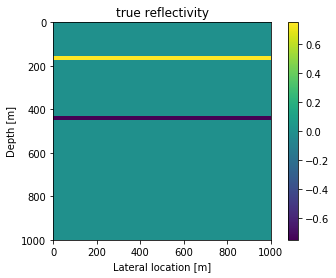

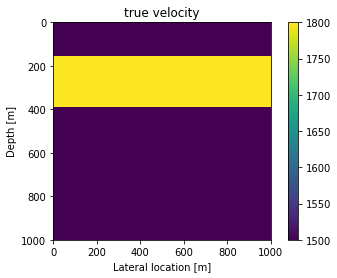

In [18]:
ntap=15
nx=51
dx=20
dz=20
nt=384
dt=0.004
nz=51
ns=25
ds=round(nx/ns)
df=1/nt/dt
fmax=20
nmod=2

nfreq=round(nt/2)
nfreq=round(fmax/df)

omega=2*m.pi*df*np.arange(1,nfreq)

c=1500


#tensorflow variables
vel = c*np.ones([nx,nz], dtype=np.complex64)
rup = np.zeros([nx,nz], dtype=np.complex64)
rdown = np.zeros([nx,nz], dtype=np.complex64)
tup = np.zeros([nx,nz], dtype=np.complex64)
tdown = np.zeros([nx,nz], dtype=np.complex64)

mask = np.ones([nx,nz], dtype=np.complex64)
for iz in range(2):
    mask[:,iz]=0

rtrue = np.zeros([nx,nz], dtype=np.complex64)
ctrue = c*np.ones([nx,nz], dtype=np.complex64)
for ix in range(nx):
    #rtrue[5+ix,15-round(0*ix/nx)]=0.75
    #rtrue[5+ix,15+round(0*ix/nx)]=-0.75
    rtrue[ix,8+round(0*ix/nx)]=0.75
    rtrue[ix,22-round(0*ix/nx)]=-0.75
    #ctrue[5+ix,15-round(0*ix/nx):12+round(0*ix/nx)]=c*1.2
    ctrue[ix,8+round(0*ix/nx):20-round(0*ix/nx)]=c*1.2

rup=rtrue
rdown=-rtrue

tup=rtrue
tup[:,0]=0
tdown=-rtrue
tdown[:,0]=0

vel=ctrue

plt.imshow(np.real(rup).transpose(),extent=[0,dx*(nx-1),dz*(nz-1),0])
plt.title('true reflectivity')
plt.axis([0,(nx-1)*dx,(nz-1)*dz,0])
plt.xlabel('Lateral location [m]')
plt.ylabel('Depth [m]')
plt.colorbar()
plt.show()
plt.imshow(np.real(vel).transpose(),extent=[0,dx*(nx-1),dz*(nz-1),0])
plt.title('true velocity')
plt.axis([0,(nx-1)*dx,(nz-1)*dz,0])
plt.xlabel('Lateral location [m]')
plt.ylabel('Depth [m]')
plt.colorbar()
plt.show()


C   =  tf.Variable(vel,name="velocity")
C0   = tf.Variable(vel)

p_plus = np.zeros([nfreq,nx,nz,ns], dtype=np.complex64)
p_minus = np.zeros([nfreq,nx,nz,ns], dtype=np.complex64)
p = np.zeros([nfreq,nx,ns], dtype=np.complex64)

for si in range(ns):
    p[:,si*ds,si]=100*ricker(fmax,nfreq,df)

P_plu  = tf.Variable(p_plus,name="Pplu")
P_min = tf.Variable(p_minus,name="Pmin")
S = tf.Variable(p,name="wavefield")
P = tf.Variable(p,name="wavefield")

Rup = tf.Variable(rup,name="reflectivity")
Gup = tf.Variable(rup,name="reflectivity")
Rdown = tf.Variable(rdown,name="reflectivity")
Tup = tf.Variable(tup,name="reflectivity")
Tdown = tf.Variable(tdown,name="reflectivity")
Mask = tf.Variable(mask,name="reflectivity")


**Next, we model the data and plot the results:**

0
down
up
1
down
up


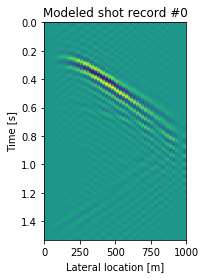

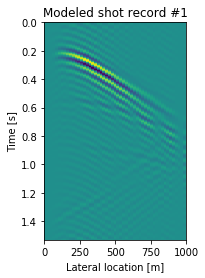

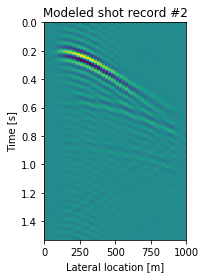

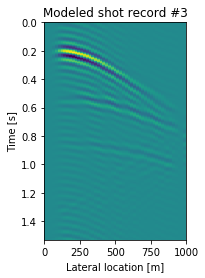

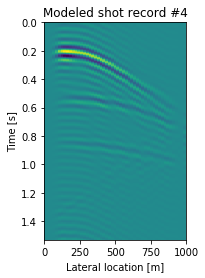

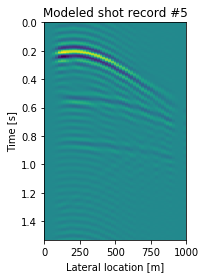

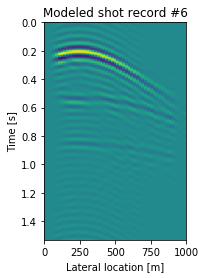

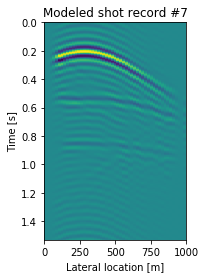

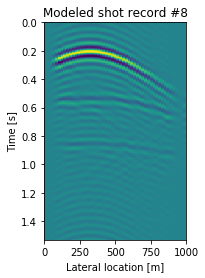

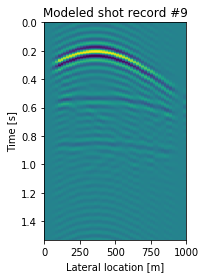

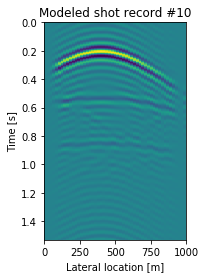

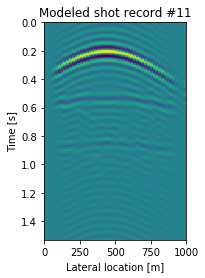

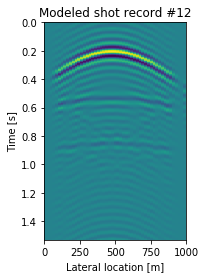

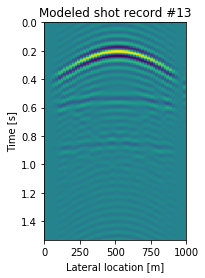

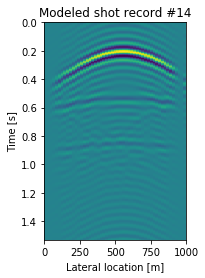

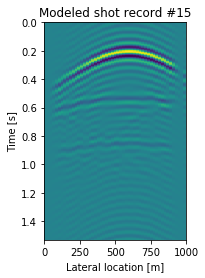

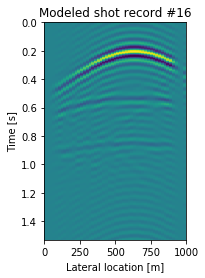

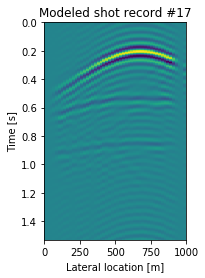

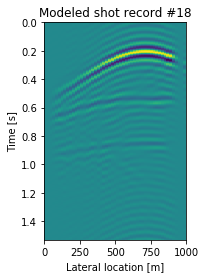

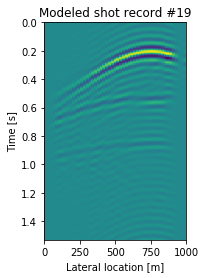

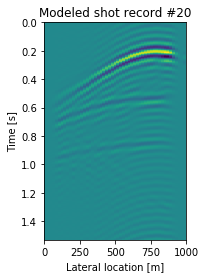

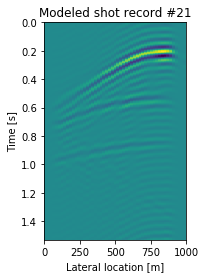

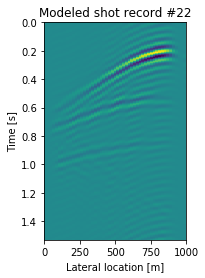

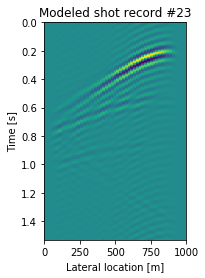

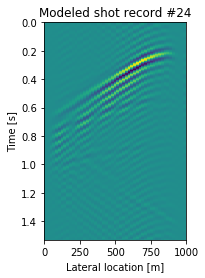

In [19]:
Pobs=FWMod(nmod,1,1,dx,df,P,S,P_plu,P_min,Rup,-Rup,Tup,Tdown,C)


pn=Pobs.numpy()
for si in range(ns):
  plt.imshow(np.reshape(np.fft.irfft(pn[:,:,round(si)],n=nt,axis=0),[nt,nx]),extent=[0,dx*(nx-1),dt*(nt-1),0],aspect=1000)
  plt.axis([0,(nx-1)*dx,(nt-1)*dt,0])
  plt.xlabel('Lateral location [m]')
  plt.ylabel('Time [s]')
  plt.title('Modeled shot record #'+str(si))
  plt.show()

**Next, we start inversion and reset some variables (set reflectivity to zero, etc..)**

0
down
up
1
down
up
Current loss: 0.0013425733+0.0000000000j


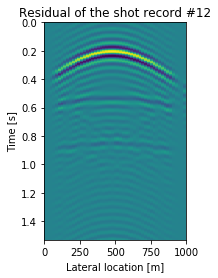

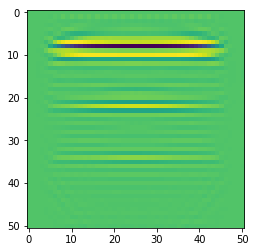

0
down
up


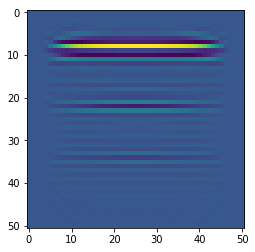

0
down
up
1
down
up
Current loss: 0.0001915578+0.0000000000j


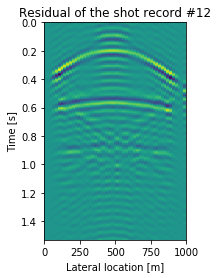

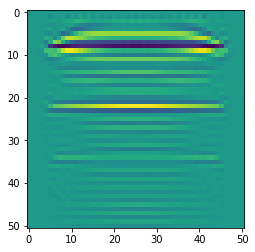

0
down
up


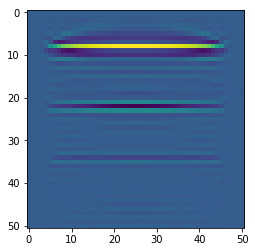

0
down


In [0]:
rtrue = np.zeros([nx,nz], dtype=np.complex64)
#ctrue = c*np.ones([nx,nz], dtype=np.complex64)
#rtrue[:,0]=-1
vel=ctrue


vel=vel.astype(dtype=np.complex64)
C   =  tf.Variable(vel,name="velocity")
C0   = tf.Variable(vel)

p_plus = np.zeros([nfreq,nz,nx,ns], dtype=np.complex64)
p_minus = np.zeros([nfreq,nz,nx,ns], dtype=np.complex64)
p = np.zeros([nfreq,nx,ns], dtype=np.complex64)
for si in range(ns):
    p[:,si*ds,si]=100*ricker(fmax,nfreq,df)
    
    
rup=rtrue
rdown=-rtrue
rdown[:,0]=0
tup=rtrue
tup[:,0]=0
tdown=-rtrue
tdown[:,0]=0

P_plu  = tf.Variable(p_plus,name="Pplu")
P_min = tf.Variable(p_minus,name="Pmin")
S = tf.Variable(p,name="wavefield")
P = tf.Variable(p,name="wavefield")

Rup = tf.Variable(rup,name="reflectivity")
Gup = tf.Variable(rup,name="reflectivity")
Rdown = tf.Variable(rdown,name="reflectivity")
Tup = tf.Variable(tup,name="reflectivity")
Tdown = tf.Variable(tdown,name="reflectivity")


loss_history = []
for i in range(5):
  with tf.GradientTape(persistent=True) as tape:
    Res=Pobs-FWMod(nmod,1,1,dx,df,P,S,P_plu,P_min,Rup,Rdown,Tup,Tdown,C)
    loss=tf.reduce_mean(Res*tf.math.conj(Res))#+pen

  pn=Res.numpy()
  plt.imshow(np.reshape(np.fft.irfft(pn[:,:,round(ns/2)],n=nt,axis=0),[nt,nx]),extent=[0,dx*(nx-1),dt*(nt-1),0],aspect=1000)
  plt.axis([0,(nx-1)*dx,(nt-1)*dt,0])
  plt.xlabel('Lateral location [m]')
  plt.ylabel('Time [s]')
  plt.title('Residual of the shot record #'+str(round(ns/2)))


  grad=tape.gradient(loss, Rup)
  
  loss_value=tf.reduce_mean(Res*tf.math.conj(Res))
  loss_history.append(loss_value.numpy())
  print("Current loss: {:.10f}".format(loss_value))

  
  plt.figure(201)
  plt.clf()
  plt.imshow(np.transpose(np.real(grad.numpy())))
  plt.pause(1)
  

  grad=Mask*(grad+tf.math.conj(grad))
  
  P_min.assign(0*P_min)
  P_plu.assign(0*P_plu)


  Psca=FWMod(1,1,1,dx,df,P,S,P_plu,P_min,grad,Rdown,Tup,Tdown,C)
  P_min.assign(0*P_min)
  P_plu.assign(0*P_plu)

  asum=tf.reduce_mean(Psca*tf.math.conj(Res))+tf.reduce_mean(Res*tf.math.conj(Psca))
  dsum=tf.reduce_mean(Psca*tf.math.conj(Psca))+tf.reduce_mean(Psca*tf.math.conj(Psca))
  Rup.assign_add(asum/dsum*grad)
  Rdown.assign_add(-asum/dsum*grad)
  Tup.assign_add(asum/dsum*grad)
  Tdown.assign_add(-asum/dsum*grad)


  plt.figure(202)
  plt.clf()
  plt.imshow(np.transpose(np.real(Rup.numpy())))
  plt.pause(1)